# Term Project  - Recurrent Autoencoder for IMDB Review Sentiment Classification

# My Table of content
- [1. Script Initialization](#initialization)
- [2. Data Load](#Dataload)
- [3. LSTM Recurrent Autoencoder](#Autoencoder)
- [4. Train the Autoencoder](#TrainEncoder)
- [5. Evaluate the Autoencoder](#EvaluateEncoder)
- [6. Train Sentiment Classifier with Frozen Encoder Layers](#FrozenEncoderSentimentClassifier)
- [7. Evaluate Sentiment Classifier with Frozen Encoder Layers](#TrainModel1)
- [8. Train Sentiment Classifier with Unfrozen Encoder Layers](#UnfrozenEncoderSentimentClassifier) 
- [9. Evaluate Sentiment Classifier with Unfrozen Encoder Layers](#TrainModel2)
- [10. Evaluate Sentiment Classifiers](#EvaluateClassifiers)

# 1. Import Necessary packages and define function  <div id='initialization'/>

### Packages

In [1]:
#seed
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import numpy as np
np.random.seed(seed_value)
import random
random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)


import keras
keras.__version__ 
import tensorflow as tf 
from keras import models
import h5py
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt 
from tensorflow import keras   
import numpy as np
import tensorflow.keras.backend as K
print(tf.keras.__version__)
import os, os.path, shutil
import time
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout 
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from os import path
import pandas as pd 
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import re
from IPython.core.display import display, HTML
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from sklearn.manifold import TSNE
from keras.utils import to_categorical

2.4.0


### Defined Functions

In [2]:
# Plotting function -  Plot training performance
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history[metric])
  plt.plot(history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
# Rounded accuracy used for autoencoder training
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [4]:
# vecotize function for converting the reviews to one hot encoding for word occurences
def vectorize_sequences(sequences, dimension=1000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences): # enumerate applies index to each IMDB movie review of word indices.
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# 2. Import the Data File <div id='Dataload'/>

1) Load the IMDB reviews importing only the top 1000 words similar to the RNN and split the test set from the validation set 

2) Select only the first 100 words of the reviews as the sentiment can often be determined from the first few sentences. The process also pads the review if length <100.

3) One hot encode the reviews so each word is presented as a 1000 vector (vocabulariy size). Each review will then be 100 x 1000 or review length x vocabulary size.

### 1) Load the data.

In [5]:
# select the top 1000 in the IMDB dataset
top_words = 1000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
(all_X_train, _), (all_X_valid, _) = imdb.load_data() # For all review words

# Split the test set from the validation
X_Valid, X_Test = X_test[:-5000], X_test[-5000:]
y_Valid, y_Test= y_test[:-5000], y_test[-5000:]

# Recurrent AutoEncoder Training set.
X_Train_RE = X_train[-7500:]  
y_Train_RE = y_train[-7500:] 

# Recurrent AutoEncoder Validation set.
X_Valid_RE = X_Valid[-1000:]  
y_Valid_RE = y_Valid[-1000:]  

In [6]:
# Summarize number of words
print("Number of unique words in training set: ")
print(len(np.unique(np.hstack(X_train))))
print("Number of unique words in validation set: ")
print(len(np.unique(np.hstack(X_Valid))))
print("Number of unique words in test set: ")
print(len(np.unique(np.hstack(X_Test))))
print("Number of unique words in the Recurrent AutoEncoder training set: ")
print(len(np.unique(np.hstack(X_Valid_RE))))
print("Number of unique words in Recurrent AutoEncoder validation set: ")
print(len(np.unique(np.hstack(X_Valid_RE))))

Number of unique words in training set: 
998
Number of unique words in validation set: 
998
Number of unique words in test set: 
998
Number of unique words in the Recurrent AutoEncoder training set: 
998
Number of unique words in Recurrent AutoEncoder validation set: 
998


In [7]:
print("Number of records in Train set: " + str (X_train.shape))
print("Number of records in Validation set: " + str (X_Valid.shape))
print("Number of records in Test set: " + str (X_Test.shape))
print("Number of records in Recurrent AutoEncoder training set: " + str (X_Train_RE.shape))
print("Number of records in Recurrent AutoEncoder validation set: " + str (X_Valid_RE.shape))
print("Classes: " + str(np.unique(y_train)))

Number of records in Train set: (25000,)
Number of records in Validation set: (20000,)
Number of records in Test set: (5000,)
Number of records in Recurrent AutoEncoder training set: (7500,)
Number of records in Recurrent AutoEncoder validation set: (1000,)
Classes: [0 1]


### 2) Pad and fix the review size to 100.

 Select the first 100 words for the review and Pad the reviews with 0's if < 100  to ensure they are all of length 100 if not already. 

In [8]:
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_Valid = sequence.pad_sequences(X_Valid, maxlen=max_review_length)
X_Test = sequence.pad_sequences(X_Test, maxlen=max_review_length)
X_Train_RE = sequence.pad_sequences(X_Train_RE, maxlen=max_review_length)
X_Valid_RE = sequence.pad_sequences(X_Valid_RE, maxlen=max_review_length)

### 3) One hot encode the reviews.

In [9]:
# one hot encode training data
X_train_encoded = to_categorical(X_train)
# one hot encode validation data
X_Valid_encoded = to_categorical(X_Valid)
# one hot encode test data
X_Test_encoded = to_categorical(X_Test)
# one hot encode Recurrent AutoEncoder Training data
X_Train_RE_encoded = to_categorical(X_Train_RE)
# one hot encode Recurrent AutoEncoder validation data
X_Valid_RE_encoded = to_categorical(X_Valid_RE)

In [10]:
print("Train set shape: " + str (X_train_encoded.shape))
print("Validation set shape: " + str (X_Valid_encoded.shape)) 
print("Test set shape: " + str (X_Test_encoded.shape))
print("Recurrent Autoencoder Train set size: " + str (X_Train_RE_encoded.shape))
print("Recurrent Autoencoder Validation set size: " + str (X_Valid_RE_encoded.shape)) 

Train set shape: (25000, 100, 1000)
Validation set shape: (20000, 100, 1000)
Test set shape: (5000, 100, 1000)
Recurrent Autoencoder Train set size: (7500, 100, 1000)
Recurrent Autoencoder Validation set size: (1000, 100, 1000)


In [11]:
# Our vectorized labels
y_Train_RE = np.asarray(y_Train_RE).astype('float32')
y_Valid_RE = np.asarray(y_Valid_RE).astype('float32')
y_Valid    = np.asarray(y_Valid).astype('float32') 
y_Test     = np.asarray(y_Test).astype('float32')
y_train    = np.asarray(y_train).astype('float32') 

# 3. Create the Reconstruction LSTM Recurrent Autoencoder <div id='Autoencoder'/>

When compiling the stacked autoencoder, we use the binary cross-entropy loss instead of the mean squared error. We are treating the reconstruction task as a multilabel binary classification problem: each word in the vocabulary at a position in the review represents the probability that the word will be oberved. The autoencoder will converge faster  when framed as a binary classification problemaccording to the MLH textbook.

In [19]:
# The subset for training the recurrent autoencoder is balanced.
np.unique(y_Train_RE, return_counts=True) 

(array([0., 1.], dtype=float32), array([3800, 3700]))

In [20]:
# Encoder
recurrent_encoder = keras.models.Sequential([ 
    keras.layers.LSTM(100,  return_sequences=True, #Tanh activation for hidden layer. 
                      input_shape=[max_review_length, top_words]), #lower dim. from input return seq. to next layer.
    keras.layers.LSTM(75 ,  return_sequences=True), #Tanh activiation for hidden layer.  
    keras.layers.LSTM(50), #Tanh activation for hidden layer with the lowest number of units (50)
])

# Decoder
recurrent_decoder = keras.models.Sequential([ 
    keras.layers.RepeatVector(max_review_length, input_shape=[50]), # RepeatVector is first, so input fed at each time step.
    keras.layers.LSTM(75,  return_sequences=True),  #Tanh activiation for hidden layer.   
    keras.layers.LSTM(100,   return_sequences=True), #Tanh activiation for hidden layer.  
    keras.layers.TimeDistributed(keras.layers.Dense(top_words, activation = 'sigmoid')) # sigmoid act. as output from 0 to 1.
])
    
# Combine the Encoder and Decoder to create the AutoEncoder model.
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

#Compile the model.
recurrent_ae.compile(loss="binary_crossentropy", optimizer= keras.optimizers.Adam(0.0001), # use the standard learning_rate=0.0001
                     metrics=[rounded_accuracy])


# save best parameter estimate using val loss.
checkpointer_ae = ModelCheckpoint("Recurrent_AutoEncoder_ModelNEW.hdf5", monitor="loss", mode="auto", #monitor training loss
                               save_best_only = True, verbose=1)

# save the training history.
csv_logger_ae = CSVLogger('RecurrentAENEW.log', separator=',', append=False) 

# compile the callbacks together
callbackser_ae = [checkpointer_ae, csv_logger_ae]

#BaseModel.summary()

In [13]:
recurrent_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 50)                518400    
_________________________________________________________________
sequential_1 (Sequential)    (None, 100, 1000)         209200    
Total params: 727,600
Trainable params: 727,600
Non-trainable params: 0
_________________________________________________________________


# 4. Train the Recurrent Autoencoder <div id='TrainEncoder'/>

In [23]:
start_time = time.time() 
history_ae = recurrent_ae.fit(X_Train_RE_encoded , X_Train_RE_encoded , epochs=20, batch_size = 50,
                              validation_data=(X_Valid_RE_encoded , X_Valid_RE_encoded ), callbacks = callbackser_ae)

print('---- %s seconds to evaluate the whole dataset ----' % (time.time() - start_time))

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.4627 - rounded_accuracy: 0.9154
Epoch 00001: loss improved from inf to 0.46268, saving model to Recurrent_AutoEncoder_ModelNEW.hdf5
150/150 [==============================] - 104s 694ms/step - loss: 0.4627 - rounded_accuracy: 0.9154 - val_loss: 0.1816 - val_rounded_accuracy: 0.9990
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.1098 - rounded_accuracy: 0.9990
Epoch 00002: loss improved from 0.46268 to 0.10985, saving model to Recurrent_AutoEncoder_ModelNEW.hdf5
150/150 [==============================] - 102s 680ms/step - loss: 0.1098 - rounded_accuracy: 0.9990 - val_loss: 0.0691 - val_rounded_accuracy: 0.9990
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 0.0523 - rounded_accuracy: 0.9990
Epoch 00003: loss improved from 0.10985 to 0.05233, saving model to Recurrent_AutoEncoder_ModelNEW.hdf5
150/150 [==============================] - 107s 711ms/step - loss: 0.0523 - ro

# 5. Evaluate the Recurrent AutoEncoder <div id='EvaluateEncoder'/>

In [14]:
# retrieve the best model weights.
recurrent_ae.load_weights("Recurrent_AutoEncoder_ModelNEW.hdf5")

history_ae = pd.read_csv('RecurrentAENEW.log', sep=',', engine='python') 

### Plot Example Reconstructions

In [30]:
# invert encoding
#inverted = argmax(encoded[0])
#print(inverted)
# Example 1
X_Train_RE_encoded_samp_0 = X_Train_RE_encoded[50].reshape(1, max_review_length, top_words)
x_0_RE_encoded_recreate = recurrent_ae.predict(X_Train_RE_encoded_samp_0, verbose=0)

# Example 2
X_Train_RE_encoded_samp_1 = X_Train_RE_encoded[75].reshape(1, max_review_length, top_words)
x_1_RE_encoded_recreate = recurrent_ae.predict(X_Train_RE_encoded_samp_1, verbose=0)

### Plot the training/validation binary cross entropy loss performance

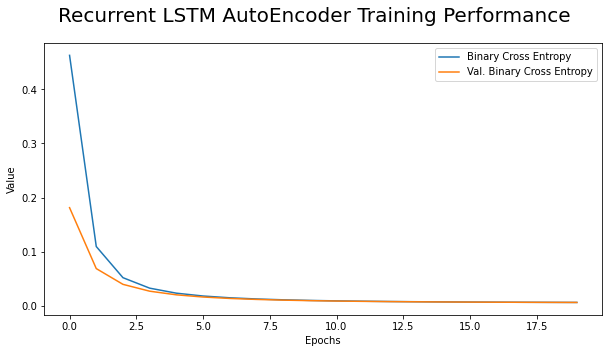

In [17]:
plt.figure(figsize=(10,5))
plt.plot(history_ae['epoch'],history_ae['loss'])
plt.plot(history_ae['epoch'], history_ae['val_loss'])
#plt.plot(history_ae['epoch'], history_ae['rounded_accuracy'])
#plt.plot(history_ae['epoch'], history_ae['val_rounded_accuracy'])
plt.suptitle('Recurrent LSTM AutoEncoder Training Performance', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel('Value')
plt.legend(['Binary Cross Entropy', 'Val. Binary Cross Entropy'
            #, 'MSE', 'Val. MSE'
           ])
#plt.savefig('RE_Loss_MSE_Training_FINAL.png')

### Visualize the Encoder Compressed IMDB Movie Reviews with t-SNE 

In [30]:
start_time = time.time() 
X_train_RE_compressed = recurrent_encoder.predict(X_Train_RE_encoded)
tsne_Encoder_RE = TSNE()
X_train_2D_RE = tsne_Encoder_RE.fit_transform(X_train_RE_compressed)
X_train_2D_RE = (X_train_2D_RE - X_train_2D_RE.min()) / (X_train_2D_RE.max() - X_train_2D_RE.min())
print('---- %s seconds to train t-SNE ----' % (time.time() - start_time))

---- 111.56789684295654 seconds to train t-SNE ----


Negative
Positive


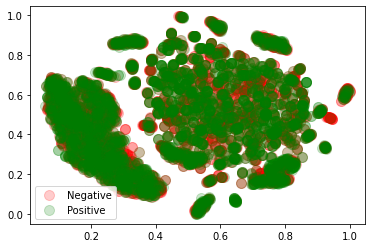

In [33]:
cdict = {'Negative': 'red', 'Positive' : 'green'}
sentiment = ['Positive' if x == 1 else 'Negative' for x in y_Train_RE]
fig, ax = plt.subplots()
for g in np.unique(sentiment):
    print(g)
    ix = np.where(np.array(sentiment) == g)
    ax.scatter(X_train_2D_RE[ix,0], X_train_2D_RE[ix,1], c = cdict[g], label = g, s = 100, alpha = 0.2)
ax.legend()
plt.show()

# 6. Sentiment Classification DNN with the frozen encoder from the Recurrent Autoencoder.  <div id='FrozenEncoderSentimentClassifier'/>

In [16]:
# Clone the encoder from the Autoencoder model
recurrent_encoder_clone   = keras.models.clone_model(recurrent_encoder)
# recurrent_encoder_clone = model.layers[i].get_weights()

# Configure the sentiment classification model
Sentiment_clf = keras.models.Sequential([
    recurrent_encoder_clone,
    keras.layers.Flatten(), 
    keras.layers.Dense(64,  activation=None, kernel_initializer = tf.keras.initializers.LecunNormal()),
    layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
    layers.Activation(activation="selu"), # Add selu activation layer 
    keras.layers.Dense(32,  activation=None, kernel_initializer = tf.keras.initializers.LecunNormal()),
    layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
    layers.Activation(activation="selu"), # Add selu activation layer 
    keras.layers.Dense(16,  activation=None, kernel_initializer = tf.keras.initializers.LecunNormal()),
    layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
    layers.Activation(activation="selu"), # Add selu activation layer 
    Dropout(rate=0.5), # Regularize the final layer with 50% dropout rate.
    keras.layers.Dense(1, activation="sigmoid", kernel_initializer = tf.keras.initializers.GlorotNormal())
])

# Freeze the encoder layer 
Sentiment_clf.layers[0].trainable = False  

#Compile the model.
Sentiment_clf.compile(loss="binary_crossentropy", 
                      optimizer= keras.optimizers.Adam(0.001), # 
                      metrics=[metrics.binary_accuracy])


# save best parameter estimate using val loss.
checkpointer_se = ModelCheckpoint("Encoder_Sentiment_Model.hdf5", monitor="val_loss", mode="auto",#monitor valid. loss
                                  save_best_only = True, verbose=1)

# save the training history.
csv_logger_se = CSVLogger('EncoderSM.log', separator=',', append=False) 

# compile the callbacks together
callbackser_se = [checkpointer_se, csv_logger_se]

In [17]:
Sentiment_clf.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 50)                518400    
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3264      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)               

# 7. Train the Encoder Sentiment Classifier with the frozen Encoder Layers <div id='TrainModel1'/>

In [18]:
start_time = time.time() 
history_se = Sentiment_clf.fit(X_train_encoded, y_train, epochs=10, batch_size = 50,
                               validation_data=(X_Valid_encoded, y_Valid), callbacks = callbackser_se)

print('---- %s seconds to evaluate the whole dataset ----' % (time.time() - start_time))

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.7467 - binary_accuracy: 0.5245
Epoch 00001: val_loss improved from inf to 0.68760, saving model to Encoder_Sentiment_Model.hdf5
500/500 [==============================] - 151s 302ms/step - loss: 0.7467 - binary_accuracy: 0.5245 - val_loss: 0.6876 - val_binary_accuracy: 0.5411
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.6891 - binary_accuracy: 0.5522
Epoch 00002: val_loss improved from 0.68760 to 0.67784, saving model to Encoder_Sentiment_Model.hdf5
500/500 [==============================] - 153s 306ms/step - loss: 0.6891 - binary_accuracy: 0.5522 - val_loss: 0.6778 - val_binary_accuracy: 0.5756
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.6797 - binary_accuracy: 0.5707
Epoch 00003: val_loss did not improve from 0.67784
500/500 [==============================] - 142s 284ms/step - loss: 0.6797 - binary_accuracy: 0.5707 - val_loss: 0.6782 - val_binary_accuracy: 0.

In [26]:
# retrieve the best model weights.
Sentiment_clf.load_weights("Encoder_Sentiment_Model.hdf5")

history_se = pd.read_csv('EncoderSM.log', sep=',', engine='python')

# 8. Sentiment Classification DNN with the unfrozen encoder from the Recurrent Autoencoder.  <div id='UnfrozenEncoderSentimentClassifier'/>

In [22]:
# Clone the encoder from the Autoencoder model
recurrent_encoder_clone2   = keras.models.clone_model(recurrent_encoder)
# recurrent_encoder_clone = model.layers[i].get_weights()

# Configure the sentiment classification model
Sentiment_clf2 = keras.models.Sequential([
    recurrent_encoder_clone2,
    keras.layers.Flatten(), 
    keras.layers.Dense(64,  activation=None, kernel_initializer = tf.keras.initializers.LecunNormal()),
    layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
    layers.Activation(activation="selu"), # Add selu activation layer 
    keras.layers.Dense(32,  activation=None, kernel_initializer = tf.keras.initializers.LecunNormal()),
    layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
    layers.Activation(activation="selu"), # Add selu activation layer 
    keras.layers.Dense(16,  activation=None, kernel_initializer = tf.keras.initializers.LecunNormal()),
    layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
    layers.Activation(activation="selu"), # Add selu activation layer 
    Dropout(rate=0.5), # Regularize the final layer with 50% dropout rate.
    keras.layers.Dense(1, activation="sigmoid", 
                       kernel_initializer = tf.keras.initializers.GlorotNormal()) # sigmoid for binary classification.
])

# Unfreeze the encoder layer 
Sentiment_clf2.layers[0].trainable = True  

#Compile the model.
Sentiment_clf2.compile(loss="binary_crossentropy", 
                      optimizer= keras.optimizers.Adam(0.0001), # use lower rate as encoder layer is already trained
                      metrics=[metrics.binary_accuracy])


# save best parameter estimate using val loss.
checkpointer_se2 = ModelCheckpoint("Encoder_Sentiment_Model2.hdf5", 
                                   monitor="val_loss", mode="auto",#monitor valid. loss
                                  save_best_only = True, verbose=1)

# save the training history.
csv_logger_se2 = CSVLogger('EncoderSM2.log', separator=',', append=False) 

# compile the callbacks together
callbackser_se2 = [checkpointer_se2, csv_logger_se2]

# 9. Train the Encoder Sentiment Classifier with the Unfrozen Encoder Layers <div id='TrainModel2'/>

In [23]:
start_time = time.time() 
history_se2 = Sentiment_clf2.fit(X_train_encoded, y_train, epochs=10, batch_size = 50,
                               validation_data=(X_Valid_encoded, y_Valid), callbacks = callbackser_se2)

print('---- %s seconds to evaluate the whole dataset ----' % (time.time() - start_time))

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.8032 - binary_accuracy: 0.5813
Epoch 00001: val_loss improved from inf to 0.75786, saving model to Encoder_Sentiment_Model2.hdf5
500/500 [==============================] - 255s 509ms/step - loss: 0.8032 - binary_accuracy: 0.5813 - val_loss: 0.7579 - val_binary_accuracy: 0.5501
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.5765 - binary_accuracy: 0.7316
Epoch 00002: val_loss improved from 0.75786 to 0.71642, saving model to Encoder_Sentiment_Model2.hdf5
500/500 [==============================] - 252s 503ms/step - loss: 0.5765 - binary_accuracy: 0.7316 - val_loss: 0.7164 - val_binary_accuracy: 0.6992
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.4623 - binary_accuracy: 0.7971
Epoch 00003: val_loss improved from 0.71642 to 0.54516, saving model to Encoder_Sentiment_Model2.hdf5
500/500 [==============================] - 246s 492ms/step - loss: 0.4623 - binary_accuracy

In [24]:
# retrieve the best model weights.
Sentiment_clf2.load_weights("Encoder_Sentiment_Model2.hdf5")

history_se2 = pd.read_csv('EncoderSM2.log', sep=',', engine='python')

# 10. Evaluate the Encoder Sentiment Classifiers <div id='EvaluateClassifiers'/>

### Plot the training/validation loss and MSE training performance

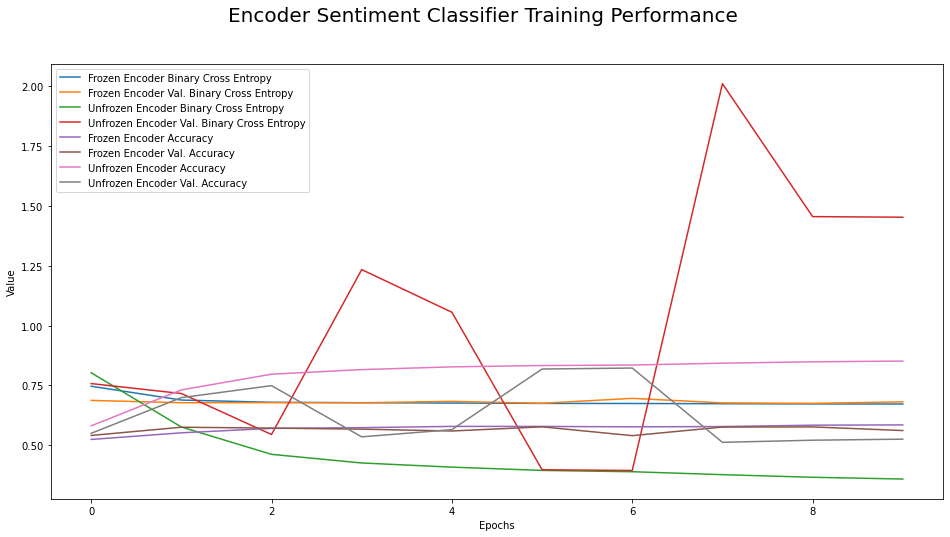

In [27]:
plt.figure(figsize=(16,8))
plt.plot(history_se['loss'])
plt.plot(history_se['val_loss'])
plt.plot(history_se2['loss'])
plt.plot(history_se2['val_loss'])
plt.plot(history_se['binary_accuracy'])
plt.plot(history_se['val_binary_accuracy'])
plt.plot(history_se2['binary_accuracy'])
plt.plot(history_se2['val_binary_accuracy'])
plt.suptitle('Encoder Sentiment Classifier Training Performance', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel('Value')
plt.legend(['Frozen Encoder Binary Cross Entropy', 'Frozen Encoder Val. Binary Cross Entropy', 
            'Unfrozen Encoder Binary Cross Entropy', 'Unfrozen Encoder Val. Binary Cross Entropy',
            'Frozen Encoder Accuracy', 'Frozen Encoder Val. Accuracy', 
            'Unfrozen Encoder Accuracy', 'Unfrozen Encoder Val. Accuracy'])
#plt.savefig('SM_Loss_MSE_Training_FINAL.png')

### Evaluate the test set accuracy.

In [28]:
# Evaluate the test set.
test_loss, test_acc = Sentiment_clf2.evaluate(X_Test_encoded, y_Test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

157/157 [==============================] - 19s 121ms/step - loss: 0.3919 - binary_accuracy: 0.8226
Test Loss: 0.39191529154777527
Test Accuracy: 0.8226000070571899
